#### 1. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
from sklearn.metrics import mean_squared_error

#### 2. Loading all the files

In [2]:
images = np.load("../../../dataset/cifar10/Ex3_cifar1025_images_cropped.npy")

In [3]:
masked_images25 = np.load("numpy/Ex3_cifar1025_masked_images.npy")
masked_images50 = np.load("numpy/Ex3_cifar1050_masked_images.npy")
masked_images75 = np.load("numpy/Ex3_cifar1075_masked_images.npy")

In [4]:
image_mean25 = np.load('numpy/Ex3_cifar1025_confidences_mean.npy')
image_mean50 = np.load('numpy/Ex3_cifar1050_confidences_mean.npy')
image_mean75 = np.load('numpy/Ex3_cifar1075_confidences_mean.npy')

In [5]:
image_std25 = np.load('numpy/Ex3_cifar1025_confidences_std.npy')
image_std50 = np.load('numpy/Ex3_cifar1050_confidences_std.npy')
image_std75 = np.load('numpy/Ex3_cifar1075_confidences_std.npy')

In [6]:
def calculate_mae(true_images, predicted_images):
    mae_total = 0.0
    num_images = len(true_images)
    for i in range(num_images):
        mae_total += np.sum(np.abs(true_images[i].flatten() - predicted_images[i].flatten()))
    return mae_total / (num_images * true_images[0].size)

In [7]:
mae25 = calculate_mae(image_mean25, images)
print("Mean Absolute Error for 25% masking is:", format(mae25, '.6f'))
mae50 = calculate_mae(image_mean50, images)
print("Mean Absolute Error for 50% masking is:", format(mae50, '.6f'))
mae75 = calculate_mae(image_mean75, images)
print("Mean Absolute Error for 75% masking is:", format(mae75, '.6f'))

Mean Absolute Error for 25% masking is: 0.060319
Mean Absolute Error for 50% masking is: 0.060184
Mean Absolute Error for 75% masking is: 0.072918


In [8]:
sum_std25 = np.sum(image_std25,axis = (1,2,3))
sum_std50 = np.sum(image_std50,axis = (1,2,3))
sum_std75 = np.sum(image_std75,axis = (1,2,3))

In [9]:
top_indices25 = np.argsort(sum_std25)[-5:]
top_indices25 = list(reversed(top_indices25))
bottom_indices25 = np.argsort(sum_std25)[:5]
print("Top 5 standard deviation sum for 25% masking are:")
for i in top_indices25:
    print(sum_std25[i])
print("Bottom 5 standard deviation sum for 25% masking are:")
for i in bottom_indices25:
    print(sum_std25[i])

Top 5 standard deviation sum for 25% masking are:
1118.6628
1116.8593
1077.4541
1074.9578
1072.7498
Bottom 5 standard deviation sum for 25% masking are:
491.99936
523.18744
553.2929
581.8141
597.28925


In [10]:
top_indices50 = np.argsort(sum_std50)[-5:]
top_indices50 = list(reversed(top_indices50))
bottom_indices50 = np.argsort(sum_std50)[:5]
print("Top 5 standard deviation sum for 50% masking are:")
for i in top_indices50:
    print(sum_std50[i])
print("Bottom 5 standard deviation sum for 50% masking are:")
for i in bottom_indices50:
    print(sum_std50[i])

Top 5 standard deviation sum for 50% masking are:
1183.5918
1167.6907
1160.2366
1157.194
1156.3315
Bottom 5 standard deviation sum for 50% masking are:
484.7484
563.4874
591.3753
610.359
613.1085


In [11]:
top_indices75 = np.argsort(sum_std75)[-5:]
top_indices75 = list(reversed(top_indices75))
bottom_indices75 = np.argsort(sum_std75)[:5]
print("Top 5 standard deviation sum for 75% masking are:")
for i in top_indices75:
    print(sum_std75[i])
print("Bottom 5 standard deviation sum for 75% masking are:")
for i in bottom_indices75:
    print(sum_std75[i])

Top 5 standard deviation sum for 75% masking are:
1367.2451
1345.2886
1335.883
1307.293
1302.097
Bottom 5 standard deviation sum for 75% masking are:
533.3484
576.08093
630.5855
649.5483
652.93475


In [12]:
def regressor_error_confidence_curve(y_pred, y_true, y_std, num_points=20, distribution="gaussian", error_metric="mae"):
    min_conf = y_std.min()
    max_conf = y_std.max()
    candidate_confs = np.linspace(min_conf, max_conf, num=num_points)

    out_confidences = []
    out_errors = []

    metric_fn = None
    metric_fn = lambda x, y: np.mean(np.abs(x - y))

    for confidence in candidate_confs:
        examples_idx = np.where(y_std >= confidence)[0]
        filt_preds = y_pred[examples_idx]
        filt_true = y_true[examples_idx]

        error = metric_fn(filt_true, filt_preds)
        out_confidences.append(confidence)
        out_errors.append(error)

    return np.array(out_confidences), np.array(out_errors)

In [13]:
image_flatten = images.flatten()
mean25_flatten = image_mean25.flatten()
std25_flatten = image_std25.flatten()
mean50_flatten = image_mean50.flatten()
std50_flatten = image_std50.flatten()
mean75_flatten = image_mean75.flatten()
std75_flatten = image_std75.flatten()

In [14]:
output_confidences_25,output_errors_25 = regressor_error_confidence_curve(mean25_flatten,image_flatten,std25_flatten)
output_confidences_50,output_errors_50 = regressor_error_confidence_curve(mean50_flatten,image_flatten,std50_flatten)
output_confidences_75,output_errors_75 = regressor_error_confidence_curve(mean75_flatten,image_flatten,std75_flatten)

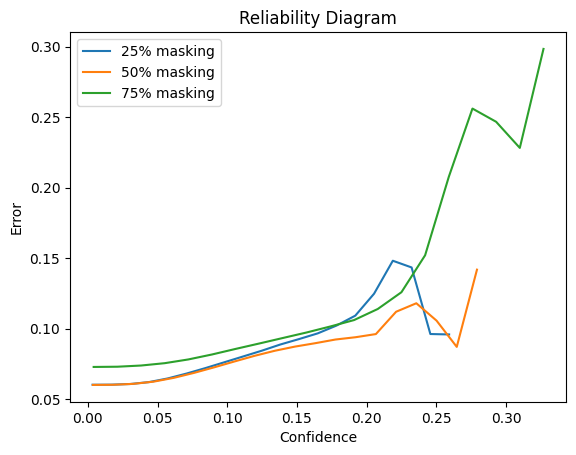

In [15]:
plt.plot(output_confidences_25, output_errors_25,label = "25% masking")   
plt.plot(output_confidences_50, output_errors_50,label = "50% masking")   
plt.plot(output_confidences_75, output_errors_75,label = "75% masking")   
plt.xlabel("Confidence")
plt.ylabel("Error")
plt.title('Reliability Diagram')
plt.legend()
plt.show()

In [16]:
new_min, new_max = 0, 1
std25_min,std25_max = image_std25.min(),image_std25.max()
std25_p = (image_std25 - std25_min)/(std25_max - std25_min)*(new_max - new_min) + new_min
std50_min,std50_max = image_std50.min(),image_std50.max()
std50_p = (image_std50 - std50_min)/(std50_max - std50_min)*(new_max - new_min) + new_min
std75_min,std75_max = image_std75.min(),image_std75.max()
std75_p = (image_std75 - std75_min)/(std75_max - std75_min)*(new_max - new_min) + new_min

In [41]:
def plot_results(original_image,masked_image, mean_image,std_image):
    w = 12
    h = 12
    fig = plt.figure(figsize=(w, h))
    columns = 4
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    plt.title('Original Image')
    plt.imshow(original_image)

    fig.add_subplot(rows, columns, 2)
    plt.axis('off')
    plt.title('Masked Image')
    plt.imshow(masked_image)

    fig.add_subplot(rows, columns, 3)
    plt.axis('off')
    plt.title('Mean Output Image')
    plt.imshow(mean_image)

    fig.add_subplot(rows, columns, 4)
    plt.axis('off')
    plt.title('Standard Deviation Image')
    plt.imshow(std_image,cmap="gray")
#     cax = plt.axes([0.95, 0.11, 0.02, 0.35])
    cax = plt.axes([0.95, 0.4, 0.02, 0.2])
    colorbar = plt.colorbar(cax =cax)
    ticks = np.array([ 0.2, 0.4, 0.6, 0.8, 1.0])
    tick_labels = ['Low', 'Medium', 'High', 'Very High', 'Max']
    # Set the tick locations and labels
    colorbar.set_ticks(ticks)
    colorbar.set_ticklabels(tick_labels)
    plt.text(0.5, - 0.1, 'Level of uncertainty in each pixel ', ha='center', fontsize=12)
    plt.show()

In [42]:
def plot_std_results(std_p_0,std_p_1,std_p_2):
    w = 12
    h = 12
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    plt.title('STD along red channel')
    plt.imshow(std_p_0,cmap="gray")

    fig.add_subplot(rows, columns, 2)
    plt.axis('off')
    plt.title('STD along blue channel')
    plt.imshow(std_p_1,cmap="gray")

    fig.add_subplot(rows, columns, 3)
    plt.axis('off')
    plt.title('STD along green channel')
    plt.imshow(std_p_2,cmap="gray")
    cax = plt.axes([0.95, 0.38, 0.02, 0.23])
    colorbar = plt.colorbar(cax =cax)
    ticks = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
    tick_labels = ['Low', 'Medium', 'High', 'Very High', 'Max']
    # Set the tick locations and labels
    colorbar.set_ticks(ticks)
    colorbar.set_ticklabels(tick_labels)
    plt.text(0.5, -0.1, 'Level of uncertainty in each channel', ha='center', fontsize=12)
    plt.show()

## 25% masking

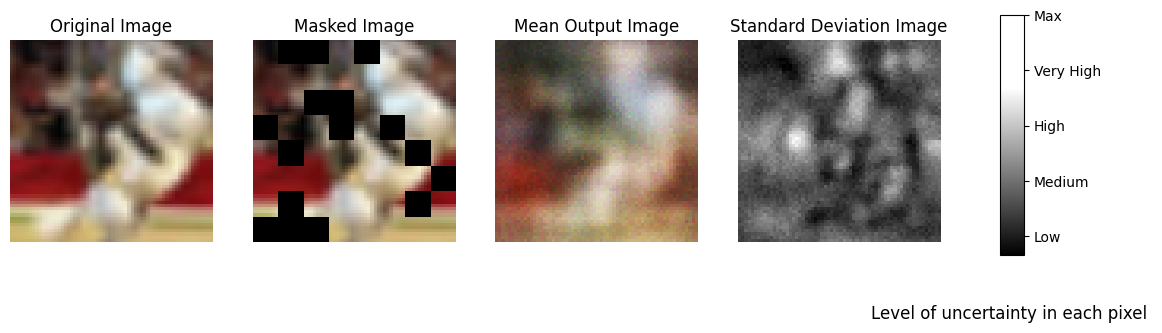

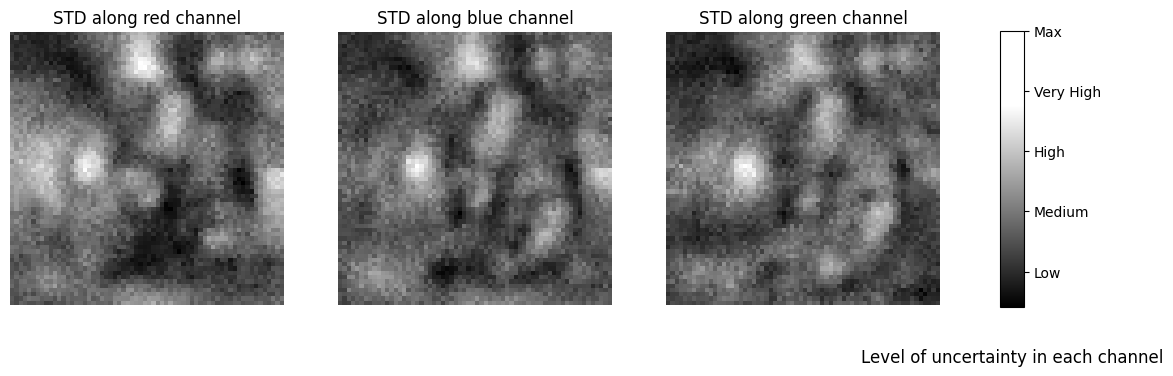

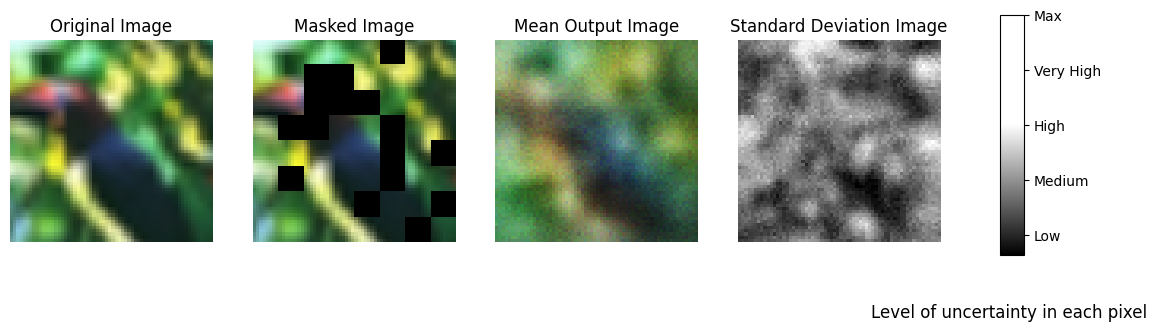

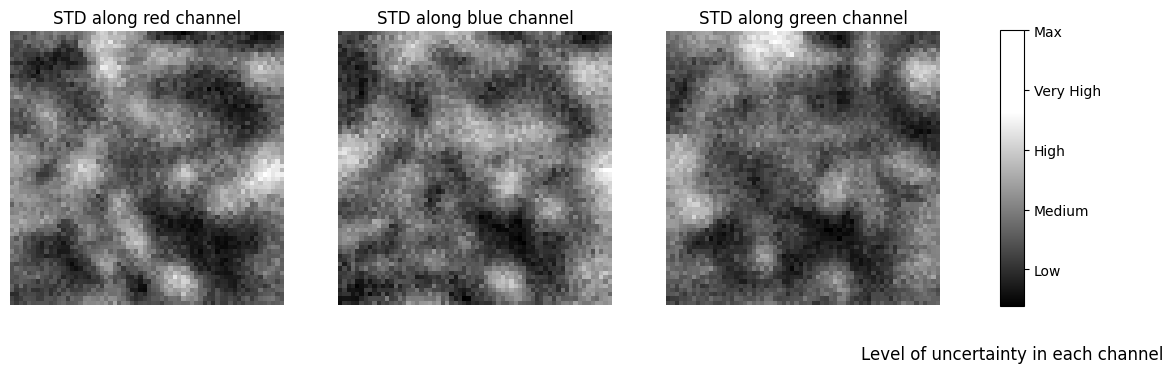

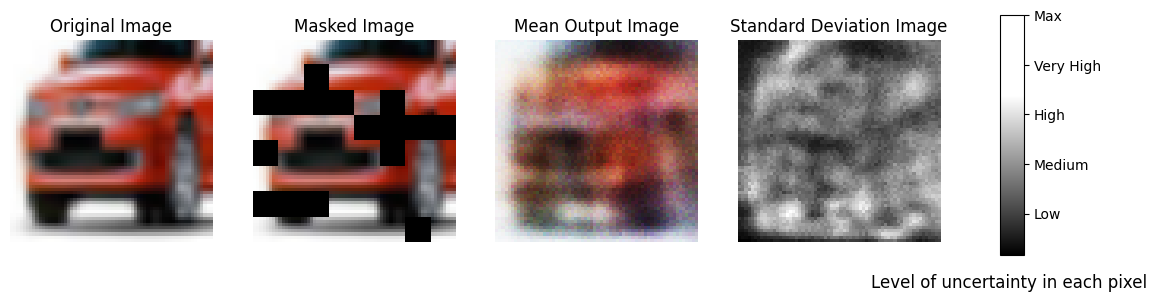

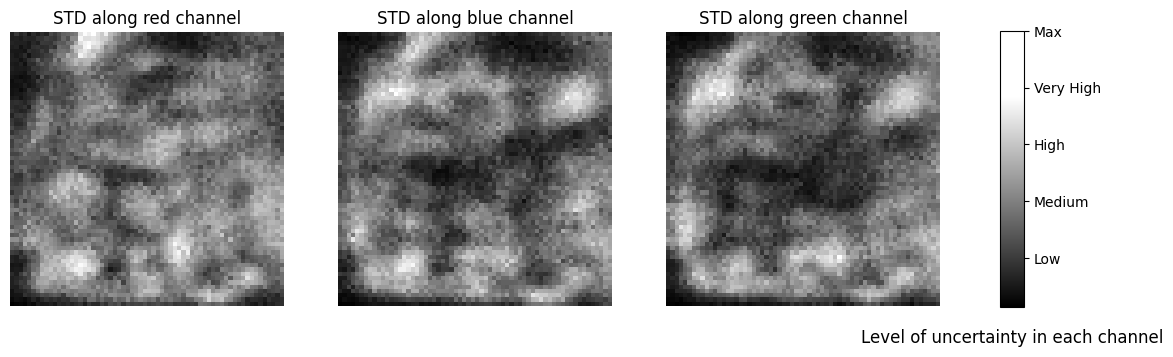

In [44]:
std25_t_0 = np.expand_dims(std25_p[top_indices25[0],:,:,0],axis=-1)
std25_t_1 = np.expand_dims(std25_p[top_indices25[0],:,:,1],axis=-1)
std25_t_2 = np.expand_dims(std25_p[top_indices25[0],:,:,2],axis=-1)
sum_std25_t = (std25_t_0 + std25_t_1 + std25_t_2)/3
original_image = images[top_indices25[0],:,:,:]
mask_image = masked_images25[top_indices25[0],:,:,:]
mean_image = image_mean25[top_indices25[0],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std25_t)
plot_std_results(std25_t_0,std25_t_1,std25_t_2)
std25_t_0 = np.expand_dims(std25_p[top_indices25[1],:,:,0],axis=-1)
std25_t_1 = np.expand_dims(std25_p[top_indices25[1],:,:,1],axis=-1)
std25_t_2 = np.expand_dims(std25_p[top_indices25[1],:,:,2],axis=-1)
sum_std25_t = (std25_t_0 + std25_t_1 + std25_t_2)/3
original_image = images[top_indices25[1],:,:,:]
mask_image = masked_images25[top_indices25[1],:,:,:]
mean_image = image_mean25[top_indices25[1],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std25_t)
plot_std_results(std25_t_0,std25_t_1,std25_t_2)
std25_t_0 = np.expand_dims(std25_p[top_indices25[2],:,:,0],axis=-1)
std25_t_1 = np.expand_dims(std25_p[top_indices25[2],:,:,1],axis=-1)
std25_t_2 = np.expand_dims(std25_p[top_indices25[2],:,:,2],axis=-1)
sum_std25_t = (std25_t_0 + std25_t_1 + std25_t_2)/3
original_image = images[top_indices25[2],:,:,:]
mask_image = masked_images25[top_indices25[2],:,:,:]
mean_image = image_mean25[top_indices25[2],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std25_t)
plot_std_results(std25_t_0,std25_t_1,std25_t_2)

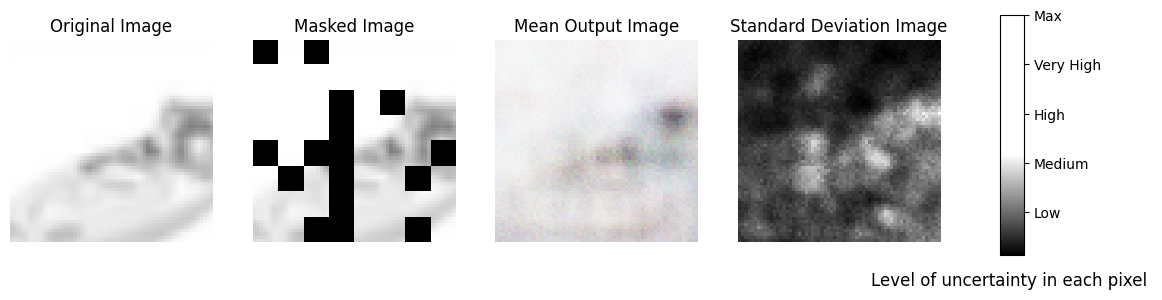

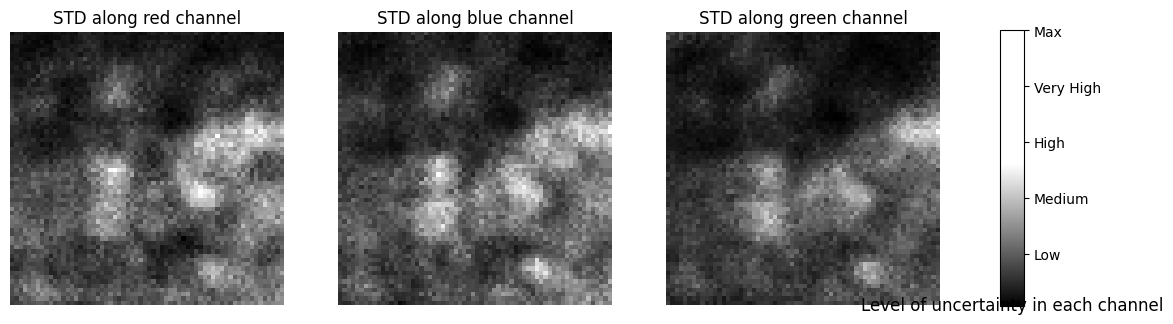

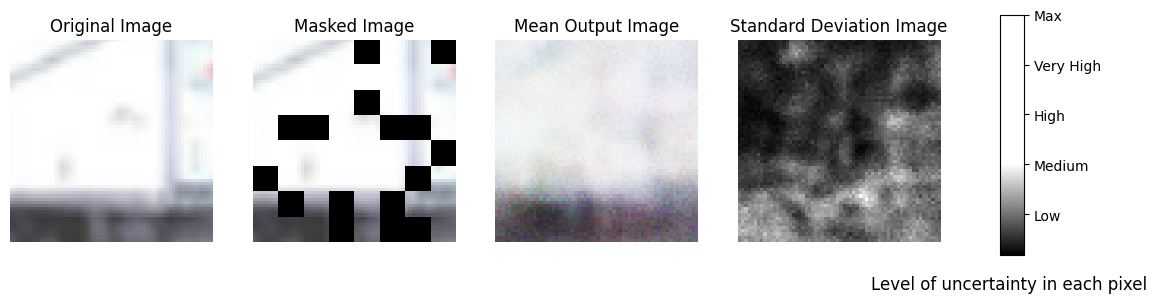

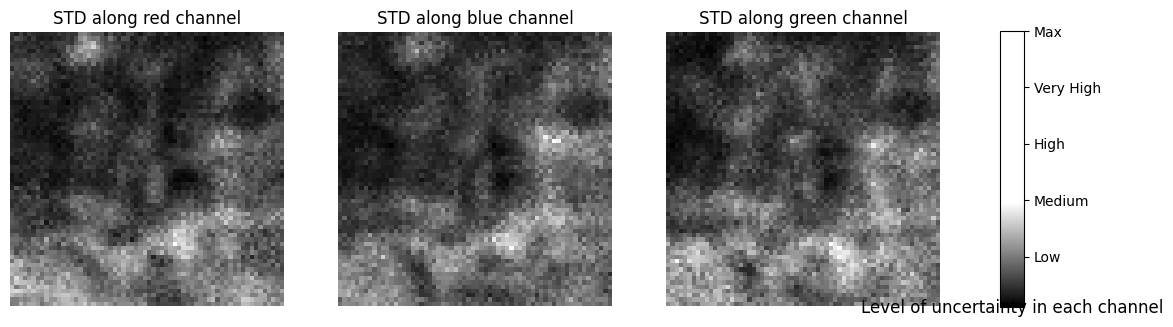

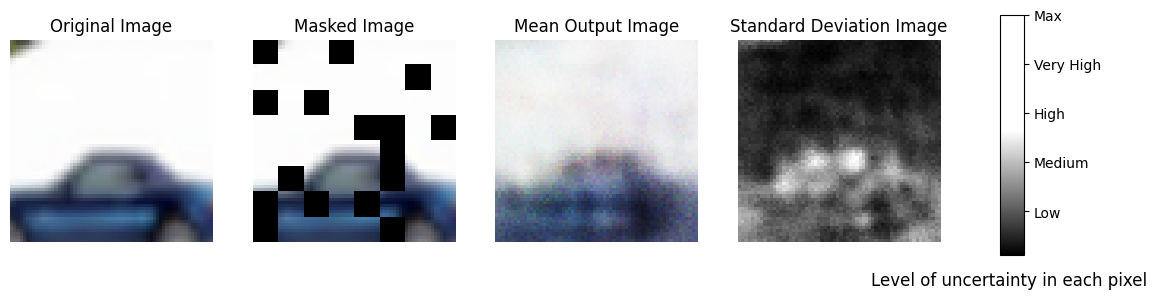

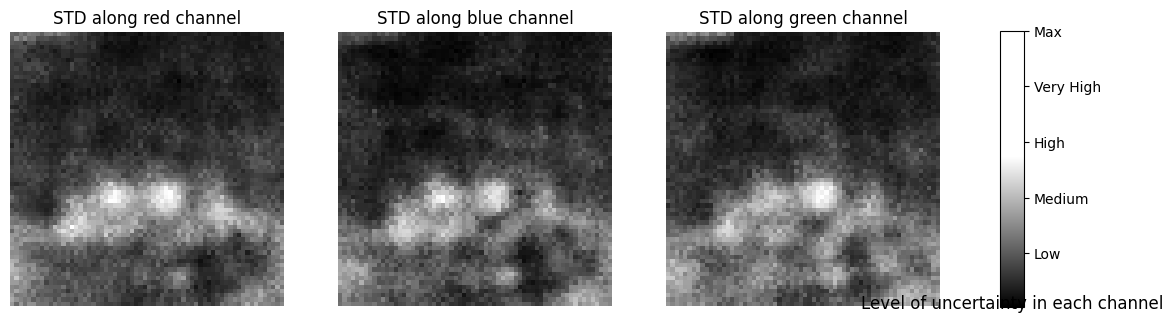

In [32]:
std25_t_0 = np.expand_dims(std25_p[bottom_indices25[0],:,:,0],axis=-1)
std25_t_1 = np.expand_dims(std25_p[bottom_indices25[0],:,:,1],axis=-1)
std25_t_2 = np.expand_dims(std25_p[bottom_indices25[0],:,:,2],axis=-1)
sum_std25_t = (std25_t_0 + std25_t_1 + std25_t_2)/3
original_image = images[bottom_indices25[0],:,:,:]
mask_image = masked_images25[bottom_indices25[0],:,:,:]
mean_image = image_mean25[bottom_indices25[0],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std25_t)
plot_std_results(std25_t_0,std25_t_1,std25_t_2)
std25_t_0 = np.expand_dims(std25_p[bottom_indices25[1],:,:,0],axis=-1)
std25_t_1 = np.expand_dims(std25_p[bottom_indices25[1],:,:,1],axis=-1)
std25_t_2 = np.expand_dims(std25_p[bottom_indices25[1],:,:,2],axis=-1)
sum_std25_t = (std25_t_0 + std25_t_1 + std25_t_2)/3
original_image = images[bottom_indices25[1],:,:,:]
mask_image = masked_images25[bottom_indices25[1],:,:,:]
mean_image = image_mean25[bottom_indices25[1],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std25_t)
plot_std_results(std25_t_0,std25_t_1,std25_t_2)
std25_t_0 = np.expand_dims(std25_p[bottom_indices25[2],:,:,0],axis=-1)
std25_t_1 = np.expand_dims(std25_p[bottom_indices25[2],:,:,1],axis=-1)
std25_t_2 = np.expand_dims(std25_p[bottom_indices25[2],:,:,2],axis=-1)
sum_std25_t = (std25_t_0 + std25_t_1 + std25_t_2)/3
original_image = images[bottom_indices25[2],:,:,:]
mask_image = masked_images25[bottom_indices25[2],:,:,:]
mean_image = image_mean25[bottom_indices25[2],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std25_t)
plot_std_results(std25_t_0,std25_t_1,std25_t_2)

## 50% masking

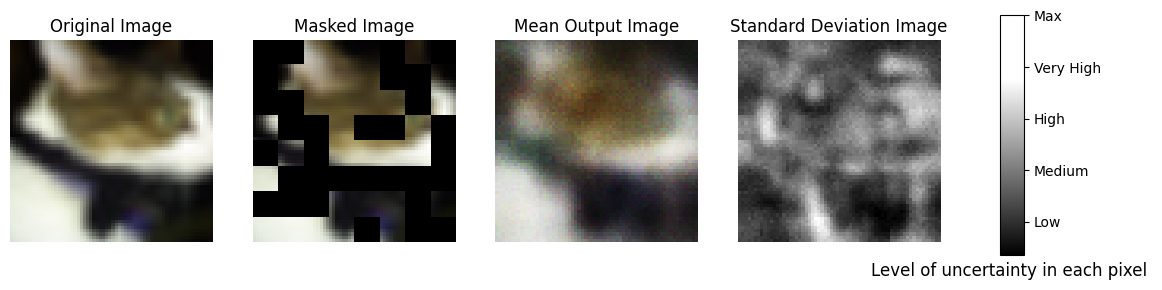

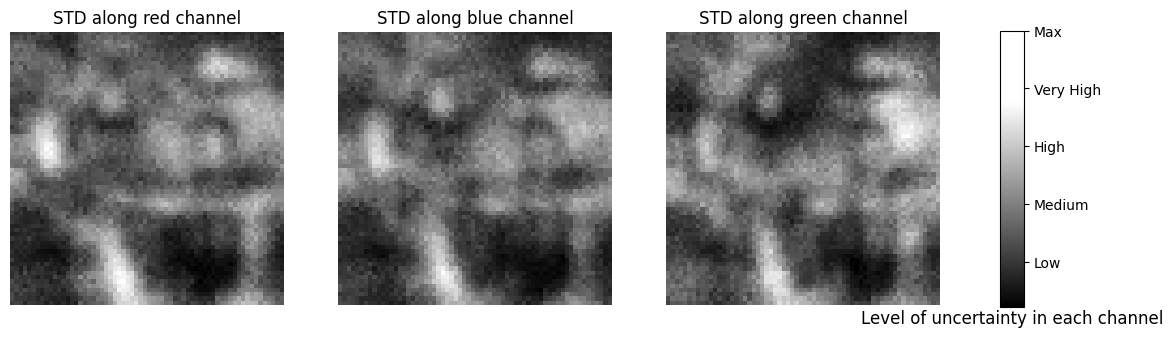

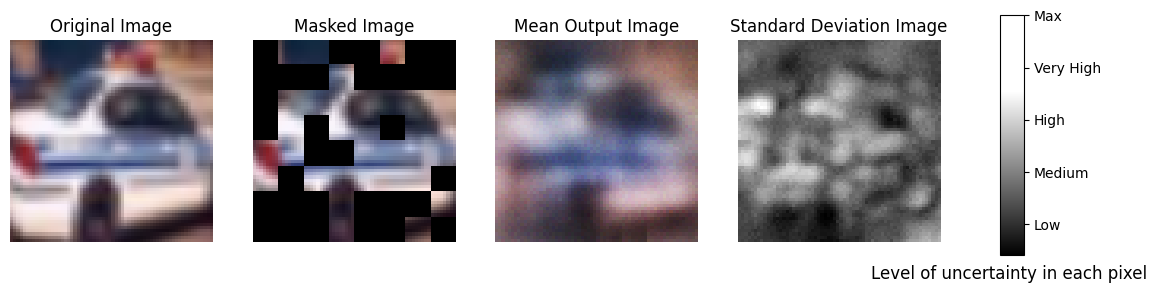

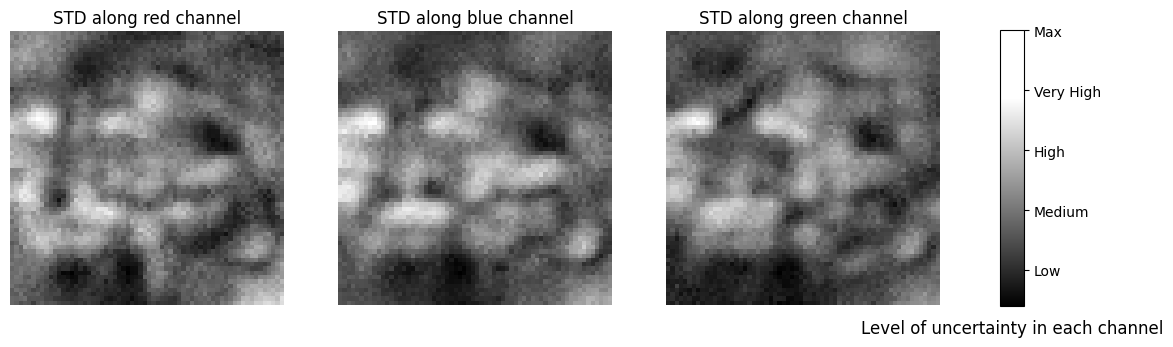

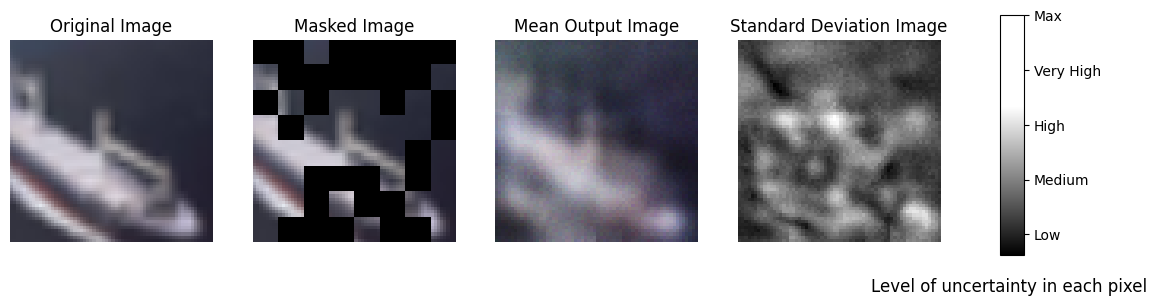

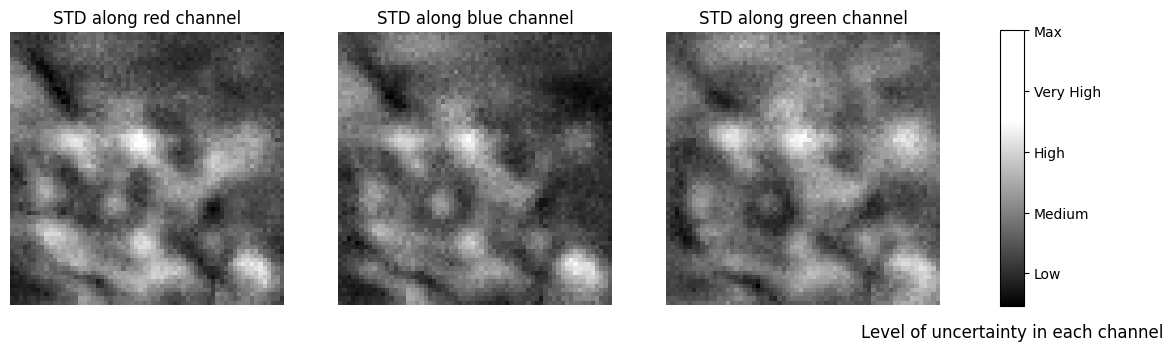

In [36]:
std50_t_0 = np.expand_dims(std50_p[top_indices50[0],:,:,0],axis=-1)
std50_t_1 = np.expand_dims(std50_p[top_indices50[0],:,:,1],axis=-1)
std50_t_2 = np.expand_dims(std50_p[top_indices50[0],:,:,2],axis=-1)
sum_std50_t = (std50_t_0 + std50_t_1 + std50_t_2)/3
original_image = images[top_indices50[0],:,:,:]
mask_image = masked_images50[top_indices50[0],:,:,:]
mean_image = image_mean50[top_indices50[0],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std50_t)
plot_std_results(std50_t_0,std50_t_1,std50_t_2)
std50_t_0 = np.expand_dims(std50_p[top_indices50[1],:,:,0],axis=-1)
std50_t_1 = np.expand_dims(std50_p[top_indices50[1],:,:,1],axis=-1)
std50_t_2 = np.expand_dims(std50_p[top_indices50[1],:,:,2],axis=-1)
sum_std50_t = (std50_t_0 + std50_t_1 + std50_t_2)/3
original_image = images[top_indices50[1],:,:,:]
mask_image = masked_images50[top_indices50[1],:,:,:]
mean_image = image_mean50[top_indices50[1],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std50_t)
plot_std_results(std50_t_0,std50_t_1,std50_t_2)
std50_t_0 = np.expand_dims(std50_p[top_indices50[2],:,:,0],axis=-1)
std50_t_1 = np.expand_dims(std50_p[top_indices50[2],:,:,1],axis=-1)
std50_t_2 = np.expand_dims(std50_p[top_indices50[2],:,:,2],axis=-1)
sum_std50_t = (std50_t_0 + std50_t_1 + std50_t_2)/3
original_image = images[top_indices50[2],:,:,:]
mask_image = masked_images50[top_indices50[2],:,:,:]
mean_image = image_mean50[top_indices50[2],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std50_t)
plot_std_results(std50_t_0,std50_t_1,std50_t_2)

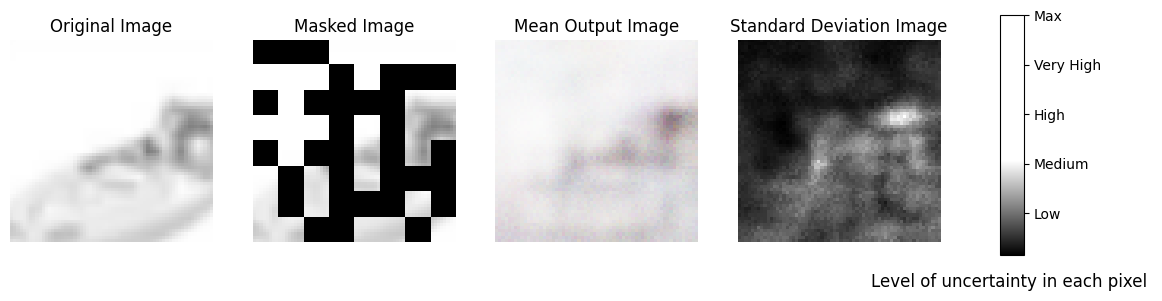

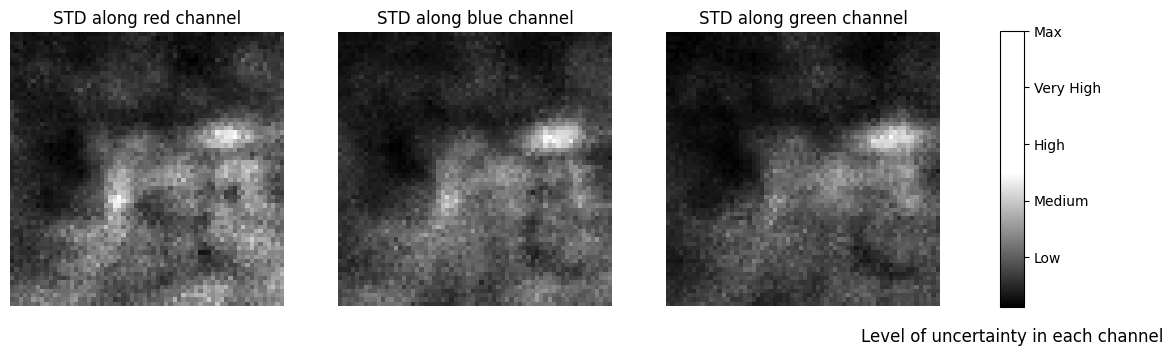

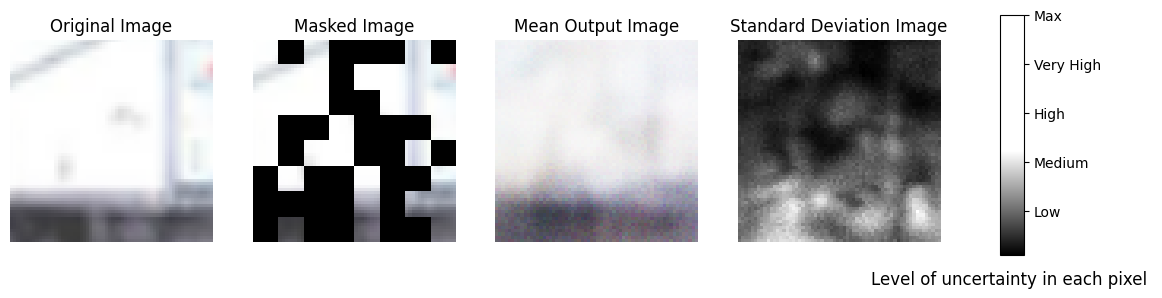

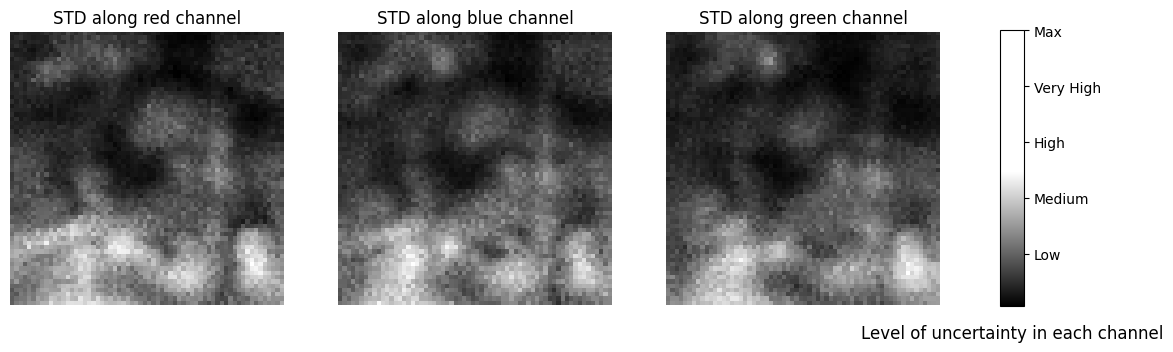

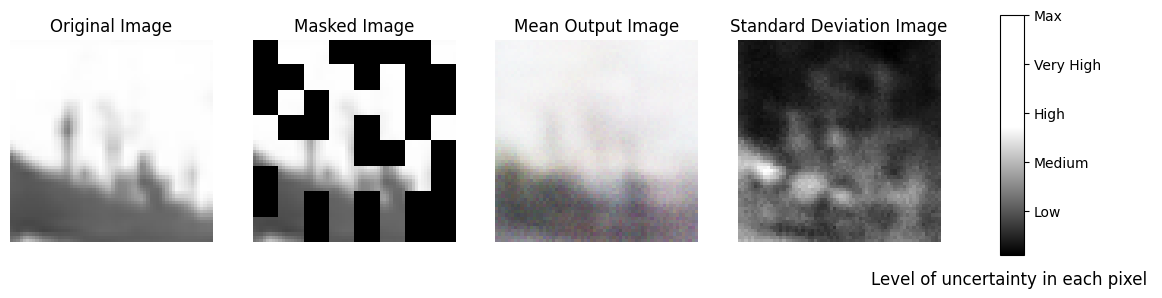

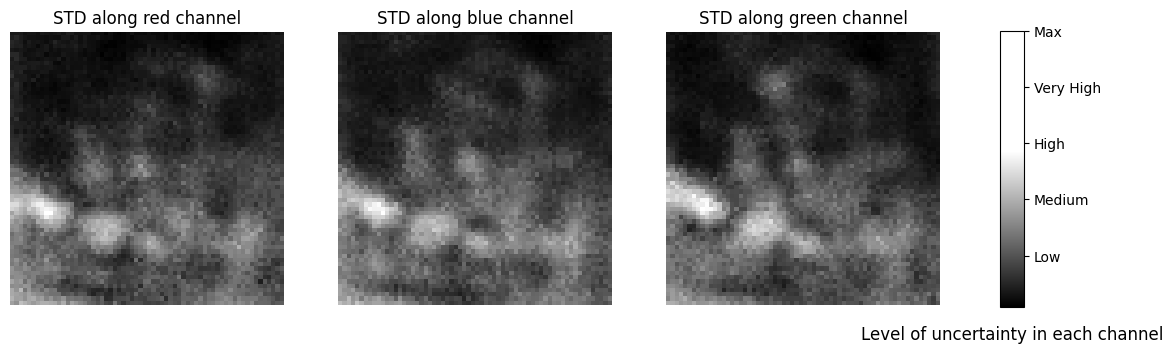

In [45]:
std50_t_0 = np.expand_dims(std50_p[bottom_indices50[0],:,:,0],axis=-1)
std50_t_1 = np.expand_dims(std50_p[bottom_indices50[0],:,:,1],axis=-1)
std50_t_2 = np.expand_dims(std50_p[bottom_indices50[0],:,:,2],axis=-1)
sum_std50_t = (std50_t_0 + std50_t_1 + std50_t_2)/3
original_image = images[bottom_indices50[0],:,:,:]
mask_image = masked_images50[bottom_indices50[0],:,:,:]
mean_image = image_mean50[bottom_indices50[0],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std50_t)
plot_std_results(std50_t_0,std50_t_1,std50_t_2)
std50_t_0 = np.expand_dims(std50_p[bottom_indices50[1],:,:,0],axis=-1)
std50_t_1 = np.expand_dims(std50_p[bottom_indices50[1],:,:,1],axis=-1)
std50_t_2 = np.expand_dims(std50_p[bottom_indices50[1],:,:,2],axis=-1)
sum_std50_t = (std50_t_0 + std50_t_1 + std50_t_2)/3
original_image = images[bottom_indices50[1],:,:,:]
mask_image = masked_images50[bottom_indices50[1],:,:,:]
mean_image = image_mean50[bottom_indices50[1],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std50_t)
plot_std_results(std50_t_0,std50_t_1,std50_t_2)
std50_t_0 = np.expand_dims(std50_p[bottom_indices50[2],:,:,0],axis=-1)
std50_t_1 = np.expand_dims(std50_p[bottom_indices50[2],:,:,1],axis=-1)
std50_t_2 = np.expand_dims(std50_p[bottom_indices50[2],:,:,2],axis=-1)
sum_std50_t = (std50_t_0 + std50_t_1 + std50_t_2)/3
original_image = images[bottom_indices50[2],:,:,:]
mask_image = masked_images50[bottom_indices50[2],:,:,:]
mean_image = image_mean50[bottom_indices50[2],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std50_t)
plot_std_results(std50_t_0,std50_t_1,std50_t_2)

## 75% masking

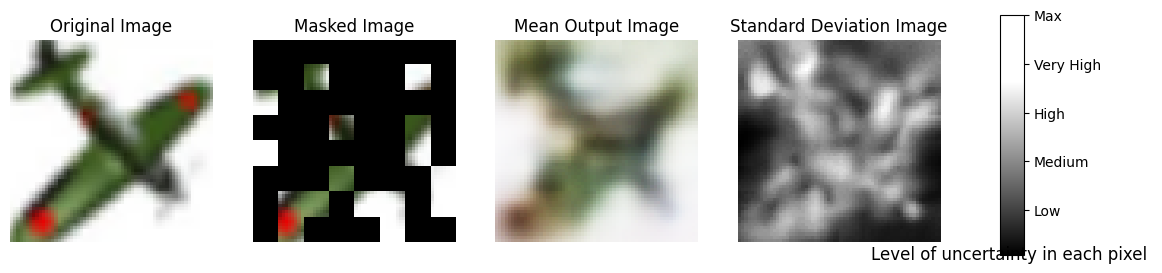

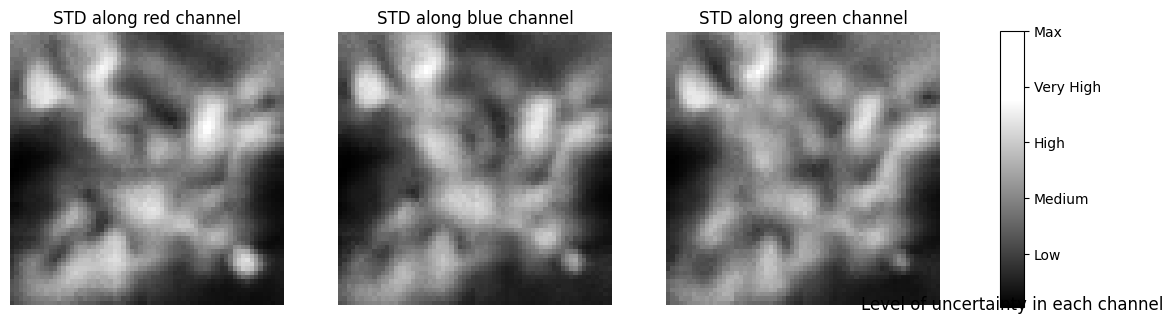

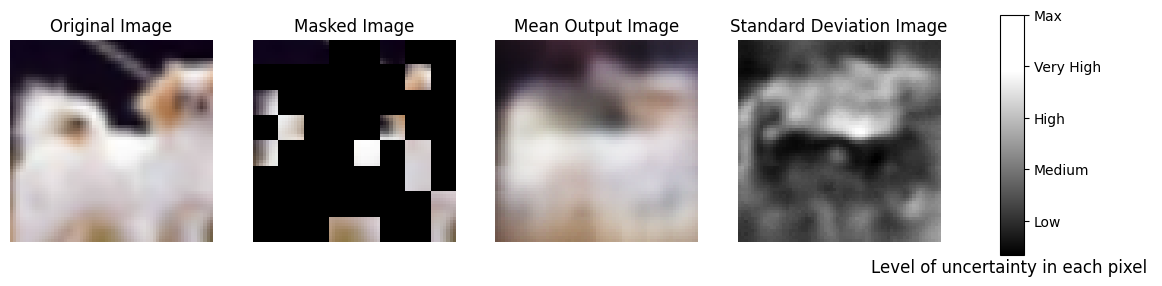

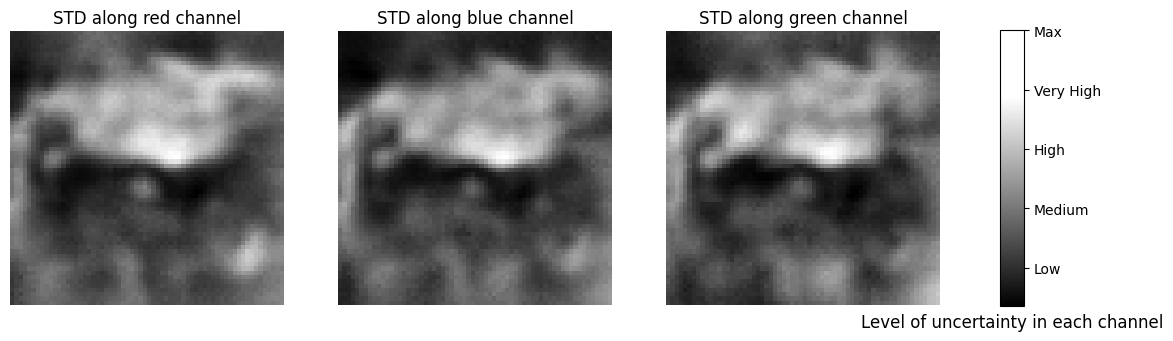

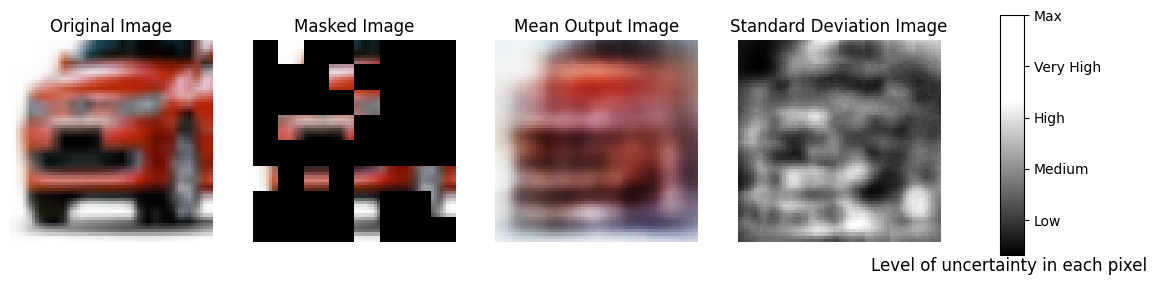

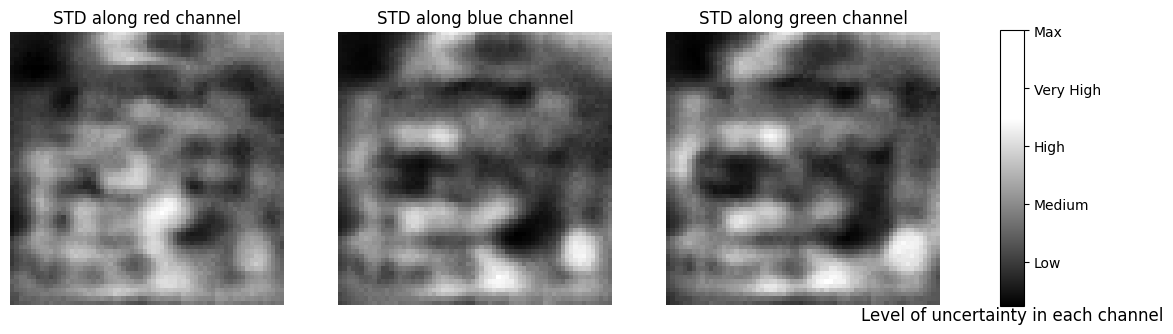

In [21]:
std75_t_0 = np.expand_dims(std75_p[top_indices75[0],:,:,0],axis=-1)
std75_t_1 = np.expand_dims(std75_p[top_indices75[0],:,:,1],axis=-1)
std75_t_2 = np.expand_dims(std75_p[top_indices75[0],:,:,2],axis=-1)
sum_std75_t = (std75_t_0 + std75_t_1 + std75_t_2)/3
original_image = images[top_indices75[0],:,:,:]
mask_image = masked_images75[top_indices75[0],:,:,:]
mean_image = image_mean75[top_indices75[0],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std75_t)
plot_std_results(std75_t_0,std75_t_1,std75_t_2)
std75_t_0 = np.expand_dims(std75_p[top_indices75[1],:,:,0],axis=-1)
std75_t_1 = np.expand_dims(std75_p[top_indices75[1],:,:,1],axis=-1)
std75_t_2 = np.expand_dims(std75_p[top_indices75[1],:,:,2],axis=-1)
sum_std75_t = (std75_t_0 + std75_t_1 + std75_t_2)/3
original_image = images[top_indices75[1],:,:,:]
mask_image = masked_images75[top_indices75[1],:,:,:]
mean_image = image_mean75[top_indices75[1],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std75_t)
plot_std_results(std75_t_0,std75_t_1,std75_t_2)
std75_t_0 = np.expand_dims(std75_p[top_indices75[2],:,:,0],axis=-1)
std75_t_1 = np.expand_dims(std75_p[top_indices75[2],:,:,1],axis=-1)
std75_t_2 = np.expand_dims(std75_p[top_indices75[2],:,:,2],axis=-1)
sum_std75_t = (std75_t_0 + std75_t_1 + std75_t_2)/3
original_image = images[top_indices75[2],:,:,:]
mask_image = masked_images75[top_indices75[2],:,:,:]
mean_image = image_mean75[top_indices75[2],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std75_t)
plot_std_results(std75_t_0,std75_t_1,std75_t_2)

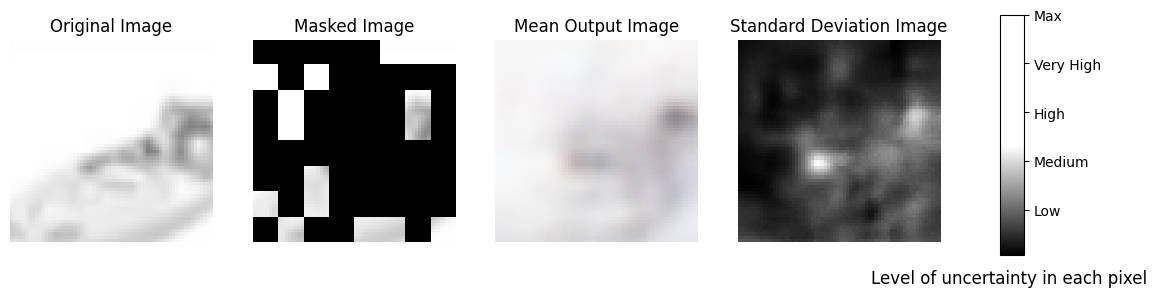

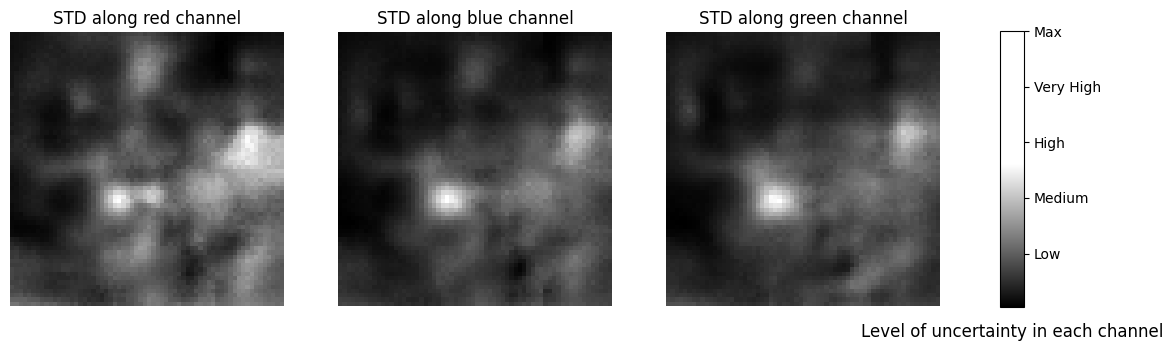

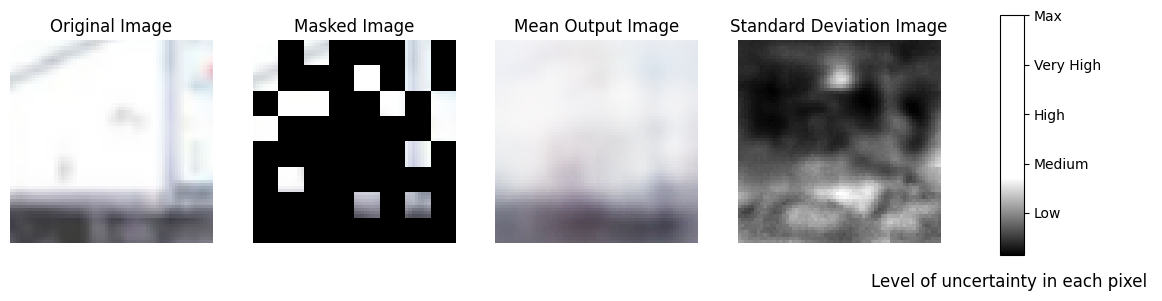

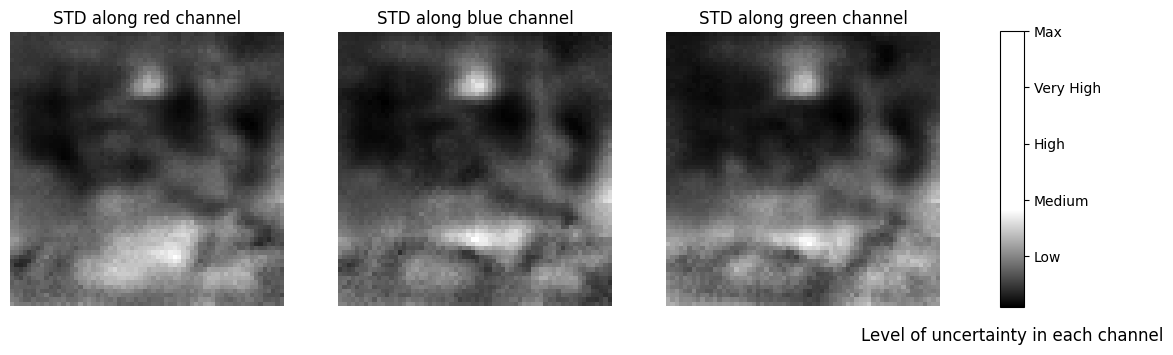

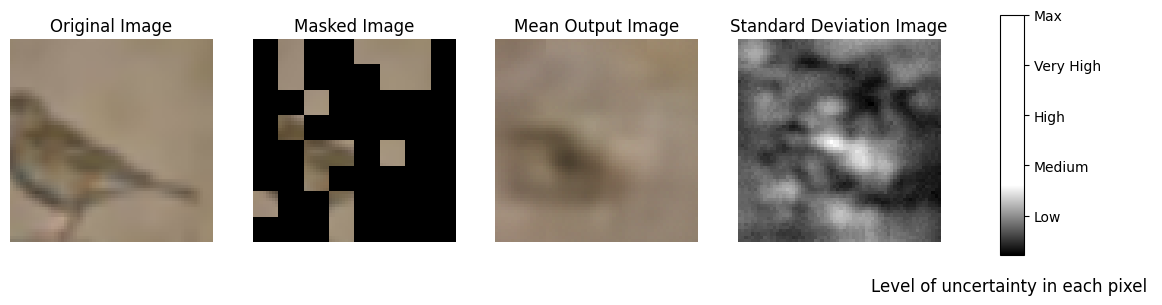

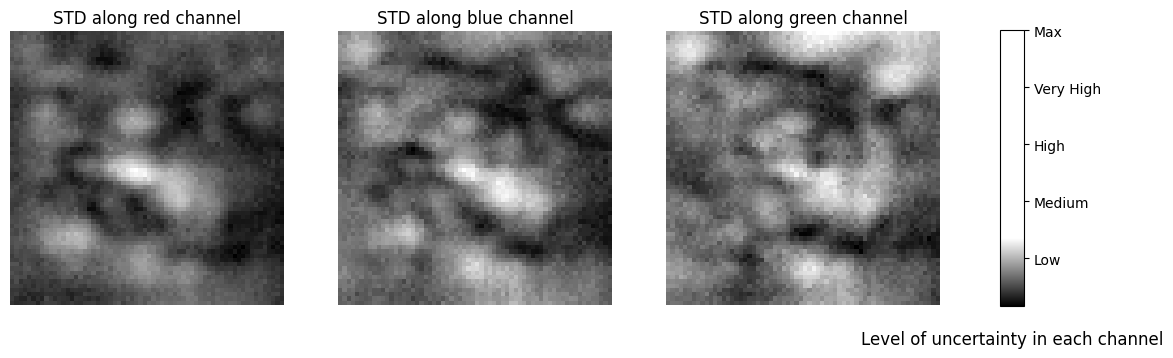

In [43]:
std75_t_0 = np.expand_dims(std75_p[bottom_indices75[0],:,:,0],axis=-1)
std75_t_1 = np.expand_dims(std75_p[bottom_indices75[0],:,:,1],axis=-1)
std75_t_2 = np.expand_dims(std75_p[bottom_indices75[0],:,:,2],axis=-1)
sum_std75_t = (std75_t_0 + std75_t_1 + std75_t_2)/3
original_image = images[bottom_indices75[0],:,:,:]
mask_image = masked_images75[bottom_indices75[0],:,:,:]
mean_image = image_mean75[bottom_indices75[0],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std75_t)
plot_std_results(std75_t_0,std75_t_1,std75_t_2)
std75_t_0 = np.expand_dims(std75_p[bottom_indices75[1],:,:,0],axis=-1)
std75_t_1 = np.expand_dims(std75_p[bottom_indices75[1],:,:,1],axis=-1)
std75_t_2 = np.expand_dims(std75_p[bottom_indices75[1],:,:,2],axis=-1)
sum_std75_t = (std75_t_0 + std75_t_1 + std75_t_2)/3
original_image = images[bottom_indices75[1],:,:,:]
mask_image = masked_images75[bottom_indices75[1],:,:,:]
mean_image = image_mean75[bottom_indices75[1],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std75_t)
plot_std_results(std75_t_0,std75_t_1,std75_t_2)
std75_t_0 = np.expand_dims(std75_p[bottom_indices75[2],:,:,0],axis=-1)
std75_t_1 = np.expand_dims(std75_p[bottom_indices75[2],:,:,1],axis=-1)
std75_t_2 = np.expand_dims(std75_p[bottom_indices75[2],:,:,2],axis=-1)
sum_std75_t = (std75_t_0 + std75_t_1 + std75_t_2)/3
original_image = images[bottom_indices75[2],:,:,:]
mask_image = masked_images75[bottom_indices75[2],:,:,:]
mean_image = image_mean75[bottom_indices75[2],:,:,:]
plot_results(original_image,mask_image,mean_image,sum_std75_t)
plot_std_results(std75_t_0,std75_t_1,std75_t_2)